In [52]:
import pandas as pd
import numpy as np

# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
# reading csv dataset file into pandas dataframe
dataset_path = '/content/gdrive/MyDrive/Ronash_DS_Assignment.csv'
df = pd.read_csv(dataset_path)

In [54]:
new_df = pd.DataFrame(columns=df.columns.tolist())
df['category'].value_counts()
for cat_name in pd.unique(df['category']).tolist():
    new_df = pd.concat([new_df, df.loc[df['category'] == cat_name][:20]], axis=0)
    
new_df['category'].value_counts()

Animals & Pet Supplies       20
Apparel & Accessories        20
Toys & Games                 20
Sporting Goods               20
Software                     20
Religious & Ceremonial       20
Office Supplies              20
Media                        20
Luggage & Bags               20
Home & Garden                20
Health & Beauty              20
Hardware                     20
Furniture                    20
Food, Beverages & Tobacco    20
Electronics                  20
Cameras & Optics             20
Business & Industrial        20
Baby & Toddler               20
Arts & Entertainment         20
Vehicles & Parts             20
Name: category, dtype: int64

In [55]:
# reading titles and tags and label columns
titles = df['title'].values.tolist()
tags = df['tags'].values.tolist()
categories = df['category'].values.tolist()
unique_categories = pd.unique(df['category'])

dataset_size = len(titles)

In [56]:
# one hot encoding the categories
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(unique_categories)
y = lb.transform(categories)

In [57]:
df.columns.tolist()

['product_id', 'title', 'vendor', 'tags', 'category']

In [58]:
!pip install keybert
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import tokenize
from keybert import KeyBERT
import nltk
nltk.download('words')

# preprocessing eteps applied on the title coulmn
def title_preprocessing(title, wordnet_lemmatizer, translator):
    title = title.translate(translator)
    title = title.lower()
    tokens = title.split()
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [i for i in tokens if i not in stopwords]
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return lemm_text
'''
preprocessing eteps applied on the tags coulmn 
(almost the same as the title_preprocessing plus keyword extracting step)
'''
def tag_preprocessing(tag, kw_model, wordnet_lemmatizer, translator):
    tag = tag.translate(translator)
    tag = tag.lower()
    keywords = kw_model.extract_keywords(tag, stop_words=None)
    tags_keywords = []
    for (key, value) in keywords:
        tags_keywords.append(key)
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in tags_keywords]
    return lemm_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [60]:
# applying preprocessing methods on tags and titles and store returned tokens for each row of the dataframe in 'X' list
X = []

kw_model = KeyBERT()
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

for idx in range(dataset_size):
    if not(idx % 1000): print(idx)
    X.append(list(set(title_preprocessing(df['title'][idx], wordnet_lemmatizer, translator) +
                      tag_preprocessing(df['tags'][idx], kw_model, wordnet_lemmatizer, translator))))

0
1000
2000
3000
4000
5000


In [61]:
concatenated_preprocessed_tokenized_X = []

for idx in range(dataset_size):
     concatenated_preprocessed_tokenized_X.append(' '.join(X[idx]))

In [62]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

n_most_common_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=n_most_common_words)
tokenizer.fit_on_texts(concatenated_preprocessed_tokenized_X)
sequences = tokenizer.texts_to_sequences(concatenated_preprocessed_tokenized_X)

concatenated_preprocessed_tokenized_X = pad_sequences(sequences, maxlen=max_len)

In [63]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

lb = LabelBinarizer()
lb.fit(unique_categories)
y = lb.transform(categories)

concatenated_preprocessed_tokenized_X, y = shuffle(concatenated_preprocessed_tokenized_X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(concatenated_preprocessed_tokenized_X , y, test_size=0.2, random_state=42)

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [65]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [66]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [18]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(20, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [25]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

from keras.callbacks import EarlyStopping
history = model.fit(X_train, y_train, 
                    batch_size=64, epochs=100, 
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001)]
                   )

Epoch 1/100
60/60 [==============================] - 3s 24ms/step - loss: 0.0146 - accuracy: 0.9971 - val_loss: 3.9158 - val_accuracy: 0.7014
Epoch 2/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0171 - accuracy: 0.9968 - val_loss: 4.0713 - val_accuracy: 0.7014
Epoch 3/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 4.2698 - val_accuracy: 0.7180
Epoch 4/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0205 - accuracy: 0.9942 - val_loss: 3.6290 - val_accuracy: 0.6919
Epoch 5/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 3.4920 - val_accuracy: 0.7227
Epoch 6/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0190 - accuracy: 0.9950 - val_loss: 3.9938 - val_accuracy: 0.7133
Epoch 7/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 4.0142 - val_accuracy: 0.7062
Epoch 

In [26]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

33/33 [==============================] - 0s 7ms/step - loss: 4.1875 - accuracy: 0.7059
Test Loss: 4.187488555908203
Test Accuracy: 0.7058823704719543


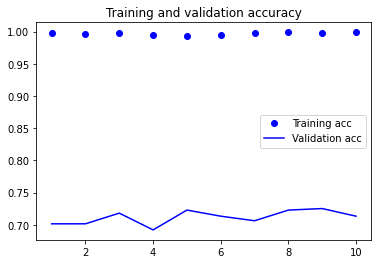

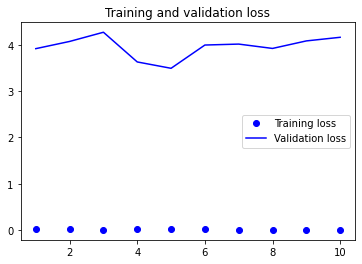

In [27]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
import numpy as np 
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
# make a joined string by concating tags and titles of each row of the df
X_new = []

for idx in range(dataset_size):
    X_new.append(df['title'][idx] + ' ' + df['tags'][idx])

In [ ]:
X_new[0]

"Fidele Super Premium Adult Large Breed Dog Food ['Adult', 'Bangalore', 'Chennai', 'Chicken', 'Doberman', 'Dog Dry Foods', 'Fidele', 'German Shepherd', 'Golden Retriever', 'Great Dane', 'HighPriority', 'Imported', 'Labrador', 'Less than 1000', 'Less than 2000', 'Less than 500', 'Mastiff', 'Orange Pet Nutrition']"

In [ ]:
'''
filtering out bad characters from the joined strings list and
the ctreate a numerical list for each sentence
'''
n_most_common_words = 8000
max_len = len(max(X,key=len))
tokenizer = Tokenizer(num_words=n_most_common_words, 
                      filters='1234567890!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_new)
sequences = tokenizer.texts_to_sequences(X_new)

X_new = pad_sequences(sequences, maxlen=max_len)

In [ ]:
X_new.shape

(5270, 27)

In [ ]:
lb = LabelBinarizer()
lb.fit(unique_categories)
y = lb.transform(categories)

# shuffling X and y to get bether results
X_new, y = shuffle(X_new, y, random_state=0)

# spling X and y into test and train sub-sets
X_train, X_test, y_train, y_test = train_test_split(X_new , y, test_size=0.2, random_state=42)

In [ ]:
# setting hyper-parameters
epochs = 100
emb_dim = 300
batch_size = 256

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# creating an LSTM based 20-classes classifier with word embedding layer
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_new.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.7))
#model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
#print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=10, min_delta=0.0001)])

((4216, 27), (4216, 20), (1054, 27), (1054, 20))
Epoch 1/100
15/15 [==============================] - 5s 170ms/step - loss: 2.9699 - acc: 0.1162 - val_loss: 2.9165 - val_acc: 0.1872
Epoch 2/100
15/15 [==============================] - 2s 143ms/step - loss: 2.8078 - acc: 0.1924 - val_loss: 2.7185 - val_acc: 0.1872
Epoch 3/100
15/15 [==============================] - 2s 145ms/step - loss: 2.6528 - acc: 0.1948 - val_loss: 2.6393 - val_acc: 0.1872
Epoch 4/100
15/15 [==============================] - 2s 140ms/step - loss: 2.5761 - acc: 0.2066 - val_loss: 2.5382 - val_acc: 0.2251
Epoch 5/100
15/15 [==============================] - 2s 136ms/step - loss: 2.4585 - acc: 0.2588 - val_loss: 2.3807 - val_acc: 0.2701
Epoch 6/100
15/15 [==============================] - 4s 286ms/step - loss: 2.2734 - acc: 0.3245 - val_loss: 2.2192 - val_acc: 0.3104
Epoch 7/100
15/15 [==============================] - 2s 138ms/step - loss: 2.0828 - acc: 0.4030 - val_loss: 2.0339 - val_acc: 0.4289
Epoch 8/100
15/15 [=

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

33/33 [==============================] - 0s 10ms/step - loss: 1.1148 - acc: 0.7524
Test Loss: 1.1148148775100708
Test Accuracy: 0.7523719072341919


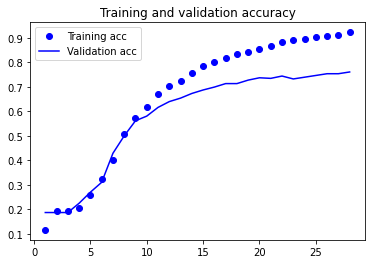

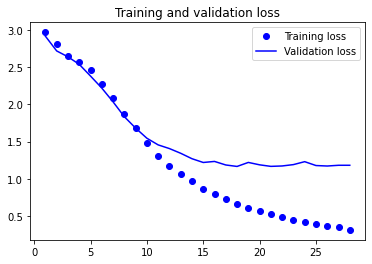

In [ ]:
# ploting train and validation metrics results throu training epochs
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# making a re-joined string out of 'X' list elements (only keywords and preprocessed tokens)
concatenated_preprocessed_tokenized_X = []

for idx in range(dataset_size):
     concatenated_preprocessed_tokenized_X.append(' '.join(X[idx]))

In [ ]:
concatenated_preprocessed_tokenized_X[0]

'nutrition super adult labrador breed doberman premium large fidele food dog dane'

In [ ]:
n_most_common_words = 8000
max_len = len(max(X,key=len))
tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)
tokenizer.fit_on_texts(concatenated_preprocessed_tokenized_X)
sequences = tokenizer.texts_to_sequences(concatenated_preprocessed_tokenized_X)

concatenated_preprocessed_tokenized_X = pad_sequences(sequences, maxlen=max_len)

In [ ]:
lb = LabelBinarizer()
lb.fit(unique_categories)
y = lb.transform(categories)

concatenated_preprocessed_tokenized_X, y = shuffle(concatenated_preprocessed_tokenized_X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(concatenated_preprocessed_tokenized_X , y, test_size=0.2, random_state=42)

In [ ]:
epochs = 100
emb_dim = 300
batch_size = 256

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=concatenated_preprocessed_tokenized_X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
#model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
#print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001)])

((4216, 27), (4216, 20), (1054, 27), (1054, 20))
Epoch 1/100
14/14 [==============================] - 5s 162ms/step - loss: 2.9363 - acc: 0.1468 - val_loss: 2.7795 - val_acc: 0.1801
Epoch 2/100
14/14 [==============================] - 2s 136ms/step - loss: 2.6780 - acc: 0.1942 - val_loss: 2.6603 - val_acc: 0.1801
Epoch 3/100
14/14 [==============================] - 2s 139ms/step - loss: 2.5869 - acc: 0.1948 - val_loss: 2.5814 - val_acc: 0.1813
Epoch 4/100
14/14 [==============================] - 2s 144ms/step - loss: 2.4577 - acc: 0.2414 - val_loss: 2.3893 - val_acc: 0.2607
Epoch 5/100
14/14 [==============================] - 2s 134ms/step - loss: 2.1780 - acc: 0.3609 - val_loss: 2.0679 - val_acc: 0.4254
Epoch 6/100
14/14 [==============================] - 2s 136ms/step - loss: 1.8224 - acc: 0.5317 - val_loss: 1.8451 - val_acc: 0.4727
Epoch 7/100
14/14 [==============================] - 2s 131ms/step - loss: 1.5056 - acc: 0.6376 - val_loss: 1.5678 - val_acc: 0.6066
Epoch 8/100
14/14 [=

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

33/33 [==============================] - 0s 10ms/step - loss: 0.9021 - acc: 0.7865
Test Loss: 0.902147114276886
Test Accuracy: 0.7865275144577026


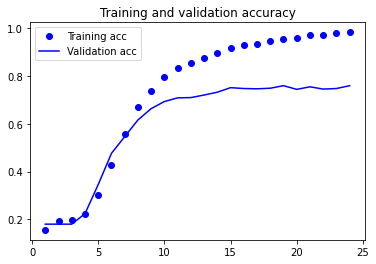

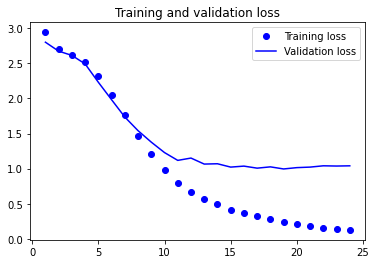

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
X = []

for idx in range(dataset_size):
    if not(idx % 1000): print(idx)
    X.append(title_preprocessing(df['title'][idx], wordnet_lemmatizer, translator) +
             tag_preprocessing(df['tags'][idx], kw_model, wordnet_lemmatizer, translator))

0
1000
2000
3000
4000
5000


In [ ]:
'''
extracting tf-idf vectors as featues for ML classifiers
(sentences are made out of re-joining preprocessed tokens)
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=50, norm='l2',
                              encoding='latin-1', ngram_range=(1, 2), stop_words='english')

concatenated_preprocessed_tokenized_X = []
for idx in range(dataset_size):
     concatenated_preprocessed_tokenized_X.append(' '.join(X[idx]))
df_X = pd.Series(concatenated_preprocessed_tokenized_X)

features = tfidfVector.fit_transform(df_X).toarray()
features.shape

(5270, 83)

In [ ]:
# categorical encodig the labels
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
lb.fit(unique_categories)
y = lb.transform(categories)

tf_idf_X, y = shuffle(features, y, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# defferent ML algorithms for evaluation
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(random_state=0, max_depth=20),
    KNeighborsClassifier(n_neighbors=5)
]

accuracies = []
for model in models:
    accuracies.append(cross_val_score(model, tf_idf_X, y, scoring='accuracy'))

for i, acc in enumerate(accuracies):
    print(models[i].__class__.__name__, 'acc =', acc.mean())

RandomForestClassifier acc = 0.3732447817836812
LinearSVC acc = 0.5231499051233396
MultinomialNB acc = 0.49810246679316894
LogisticRegression acc = 0.522011385199241
DecisionTreeClassifier acc = 0.444022770398482
KNeighborsClassifier acc = 0.46622390891840604


In [ ]:
'''
 extracting tf-idf vectors as featues for ML classifiers 
(sentences are made out of concating title and tags columns)
'''
X_new = []
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

for idx in range(dataset_size):
    sentence = df['title'][idx] + ' ' + df['tags'][idx]
    sentence = sentence.translate(translator)
    sentence = sentence.lower()
    X_new.append(sentence)
df_X = pd.Series(X_new)

features = tfidfVector.fit_transform(df_X).toarray()

lb = LabelEncoder()
lb.fit(unique_categories)
y = lb.transform(categories)
tf_idf_X, y = shuffle(features, y, random_state=0)

accuracies = []
for model in models:
    accuracies.append(cross_val_score(model, tf_idf_X, y, scoring='accuracy'))

for i, acc in enumerate(accuracies):
    print(models[i].__class__.__name__, 'acc =', acc.mean())

RandomForestClassifier acc = 0.3428842504743833
LinearSVC acc = 0.5768500948766604
MultinomialNB acc = 0.5502846299810248
LogisticRegression acc = 0.5764705882352942
DecisionTreeClassifier acc = 0.43074003795066407
KNeighborsClassifier acc = 0.5030360531309299
